In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from src.data.dataloader import DataLoader
from src.utils.plots import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dataloader = DataLoader()

In [12]:
characters = dataloader.load_characters()
print(len(characters))
characters.head()

450787


,wikipedia_movie_id,wikidata_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height_meters,actor_name,actor_age_at_release,ethnicity,wikidata_character_id,wikidata_actor_id
0,975900,Q261700,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,NaN,NaN,Q1873468
1,975900,Q261700,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,NaN,NaN,Q230527
2,975900,Q261700,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,African Americans,NaN,Q173637
3,975900,Q261700,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,NaN,NaN,Q169963
4,975900,Q261700,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,NaN,NaN,Q233347


In [44]:
movies_with_characters = dataloader.load_movies_with_characters()

movies_with_characters.loc[movies_with_characters['Movie release date'] == '1010', 'Movie release date'] = '2010'

print(len(movies_with_characters))
movies_with_characters.head()

64330


,wikipedia_movie_id,wikidata_movie_id,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,character_name,actor_gender,actor_height_meters,actor_age_at_release,ethnicity,plot
0,330,Q2823770,Actrius,1996,NaN,90.0,"Catalan language, Spanish Language",Spain,"Drama, Comedy-drama","nan, nan, nan, nan","F, F, F, F","nan, nan, nan, nan","54.0, 29.0, 51.0, 60.0","Spaniards, nan, nan, nan",In order to prepare the role of an important o...
1,3217,Q471992,Army of Darkness,1992,21502796.0,81.0,English Language,United States of America,"Cult, Horror, Stop motion, Costume drama, Acti...","S-Mart Clerk, Fake shemp, Ash Williams, Evil A...","M, M, M, M, M, F, F, F, M, M, M, nan, M, M","1.87, nan, 1.85, 1.85, 1.87, 1.68, 1.73, 1.75,...","26.0, 36.0, 34.0, 34.0, 26.0, 28.0, 27.0, 35.0...","nan, nan, nan, nan, nan, White Americans, Fren...","After being pulled through a time portal, Ash ..."
2,3333,Q220394,The Birth of a Nation,1915,50000000.0,190.0,"Silent film, English Language",United States of America,"Silent film, Indie, Costume drama, Epic, Black...","nan, nan, nan, nan, nan, nan, nan, nan, nan, n...","F, M, F, M, M, F, M, M, M, M, F, F, F, M","1.66, nan, 1.6, nan, nan, nan, 1.8, nan, nan, ...","nan, nan, nan, nan, nan, 11.0, nan, nan, nan, ...","nan, nan, nan, nan, nan, nan, nan, nan, nan, n...",The film follows two juxtaposed families: the...
3,3746,Q184843,Blade Runner,1982,33139618.0,116.0,"Japanese Language, Cantonese, English Language...","United States of America, Hong Kong","Thriller, Cyberpunk, Science Fiction, Future n...","J.F. Sebastian, Rick Deckard, Roy Batty, Racha...","M, M, M, F, F, F, M, M, M, M, M, M, M, M, nan","1.727, 1.85, 1.85, 1.753, 1.78, 1.753, 1.905, ...","34.0, 39.0, 38.0, 22.0, 21.0, 36.0, 37.0, 37.0...","nan, German Americans, Dutch, nan, nan, nan, n...","{{Hatnote}} In Los Angeles, November 2019, ret..."
4,3837,Q957323,Blazing Saddles,1974,119500000.0,93.0,"Yiddish Language, English Language",United States of America,"Western, Satire, Comedy","Gabby Johnson, Taggart, nan, Rev. Johnson, Mon...","M, M, M, M, M, M, M, M, M, F, M, M, M, M, F, M...","nan, 1.91, nan, 1.7, 1.88, 1.78, nan, nan, 1.6...","37.0, 54.0, 64.0, 57.0, 38.0, 40.0, 43.0, 35.0...","nan, nan, nan, nan, nan, Italian Americans, na...","In the American Old West of 1874, construction..."


<Figure size 1200x600 with 0 Axes>

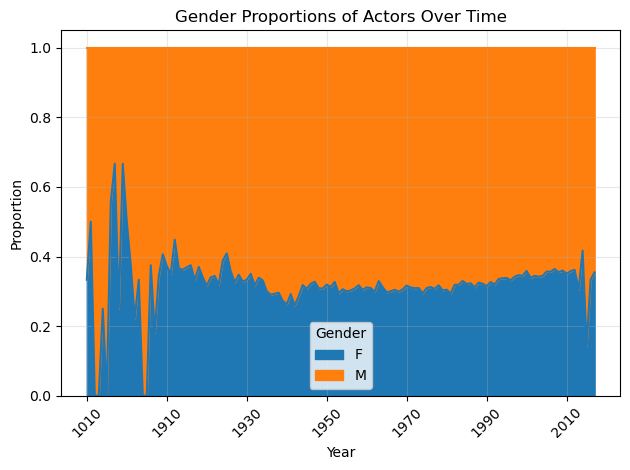

In [32]:
plot_gender_proportions(movies_with_characters)

<Figure size 1200x600 with 0 Axes>

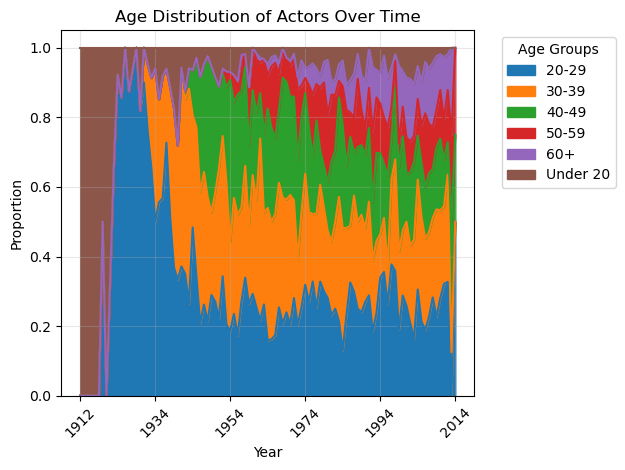

In [34]:
# Call the function
plot_age_proportions(movies_with_characters)

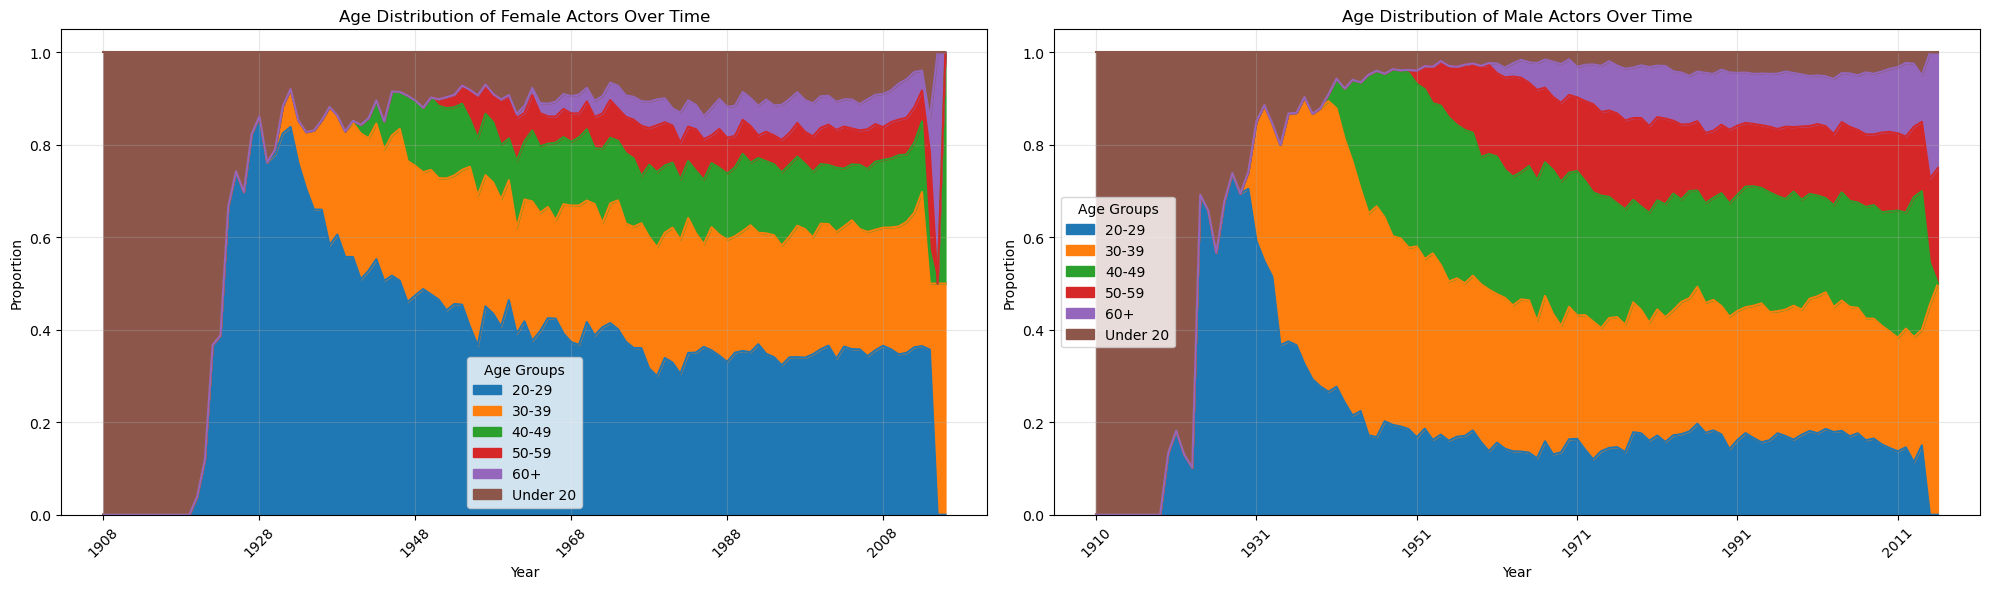

In [39]:
plot_age_proportions_by_gender(movies_with_characters)

In [ ]:
from concurrent.futures import ThreadPoolExecutor

def get_revenue(wikidata_id):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbgetentities",
        "ids": wikidata_id,
        "format": "json",
        "languages": "en",
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        if "entities" in data and wikidata_id in data["entities"]:
            claims = data["entities"][wikidata_id]["claims"]
            if "P2142" in claims:
                box_office_claim = claims["P2142"][0]["mainsnak"]["datavalue"]["value"]
                return float(box_office_claim["amount"])
            else:
                return None
        else:
            return None
    except requests.exceptions.RequestException:
        return None

# Assume get_revenue is already defined
def update_movie_revenue(movie_df):
    def process_row(index, row):
        if pd.notna(row["Movie box office revenue"]):
            return index, row["Movie box office revenue"]

        revenue = get_revenue(row["wikidata_movie_id"])
        if revenue == 0:
            revenue = None

        print(f"revenue for index {index}: {revenue}")
        return index, revenue

    # Create a thread pool executor
    with ThreadPoolExecutor() as executor:
        # Submit tasks to the thread pool
        futures = {
            executor.submit(process_row, index, row): index
            for index, row in movie_df.iterrows()
        }

        # Wait for each future to complete and update the DataFrame
        for future in futures:
            index, revenue = future.result()
            movie_df.at[index, "Movie box office revenue"] = revenue

    return movie_df


# print the number of movies with revenue
print(
    len(
        movies_with_characters[
            movies_with_characters["Movie box office revenue"].notna()
        ]
    )
)
movies_with_characters = update_movie_revenue(movies_with_characters)
# print the new number of movies with revenue
print(
    len(
        movies_with_characters[
            movies_with_characters["Movie box office revenue"].notna()
        ]
    )
)

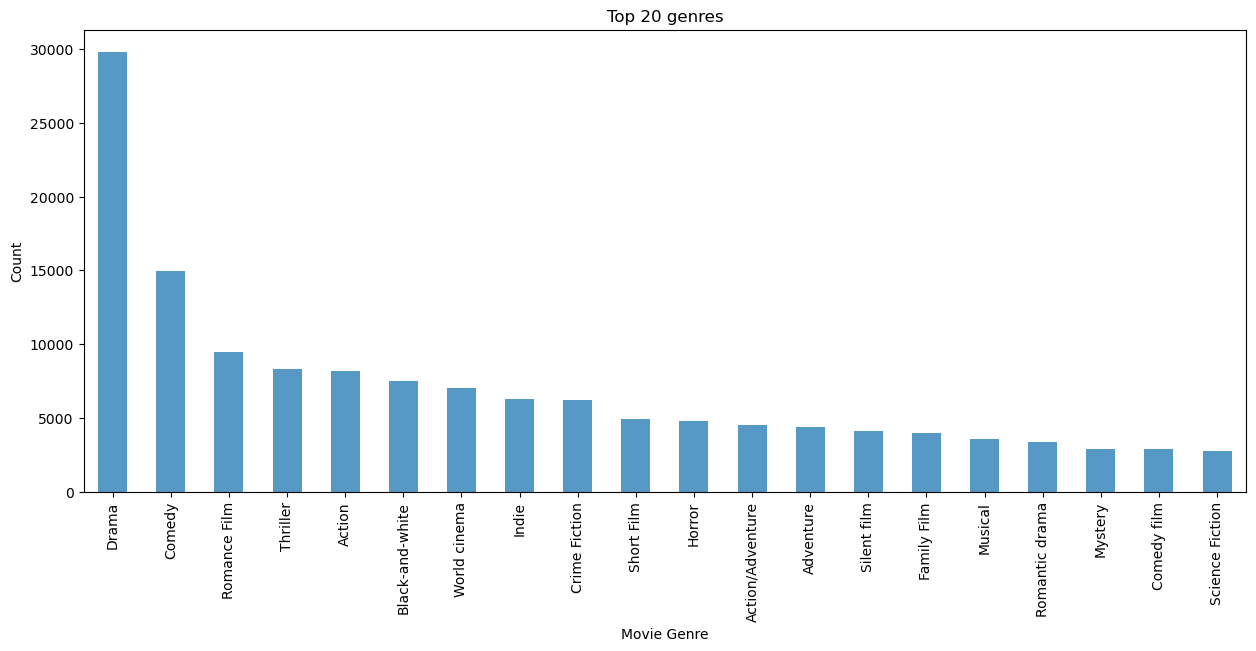

In [38]:
plot_top_genres(movies_with_characters)

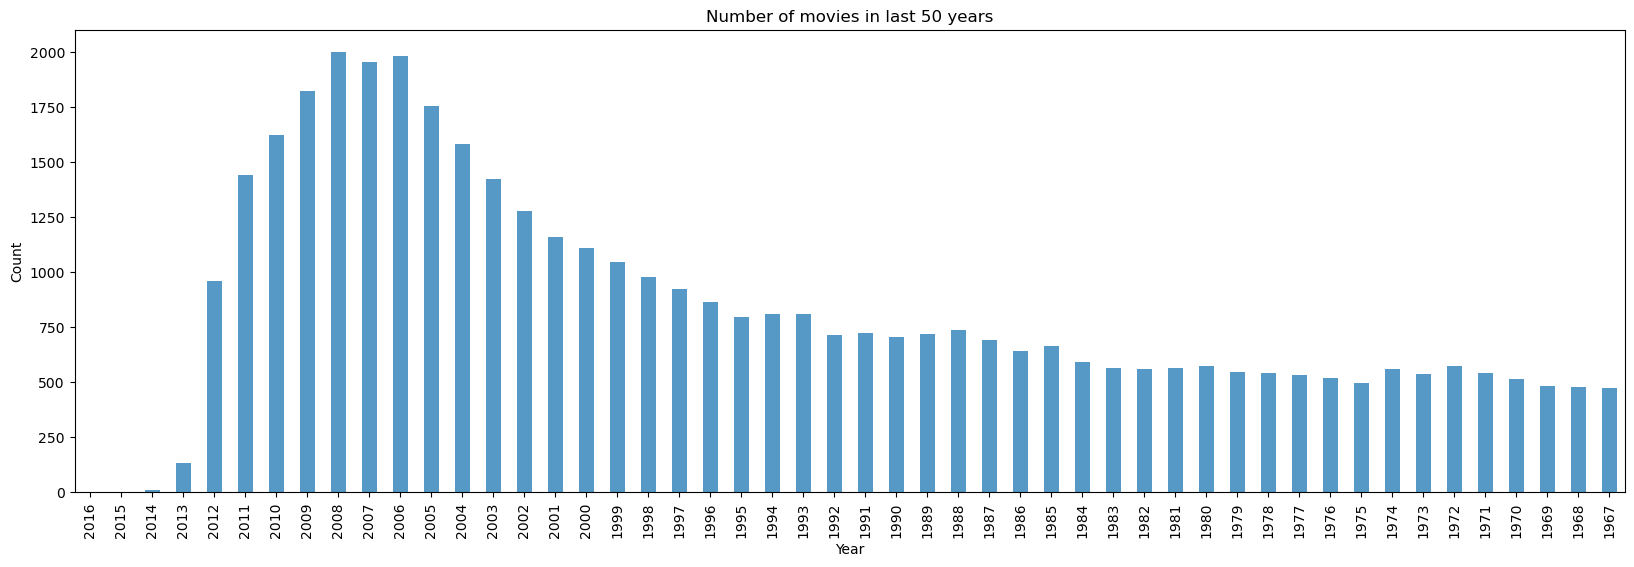

In [41]:
plot_movies_by_year(movies_with_characters)

<Figure size 1500x800 with 0 Axes>

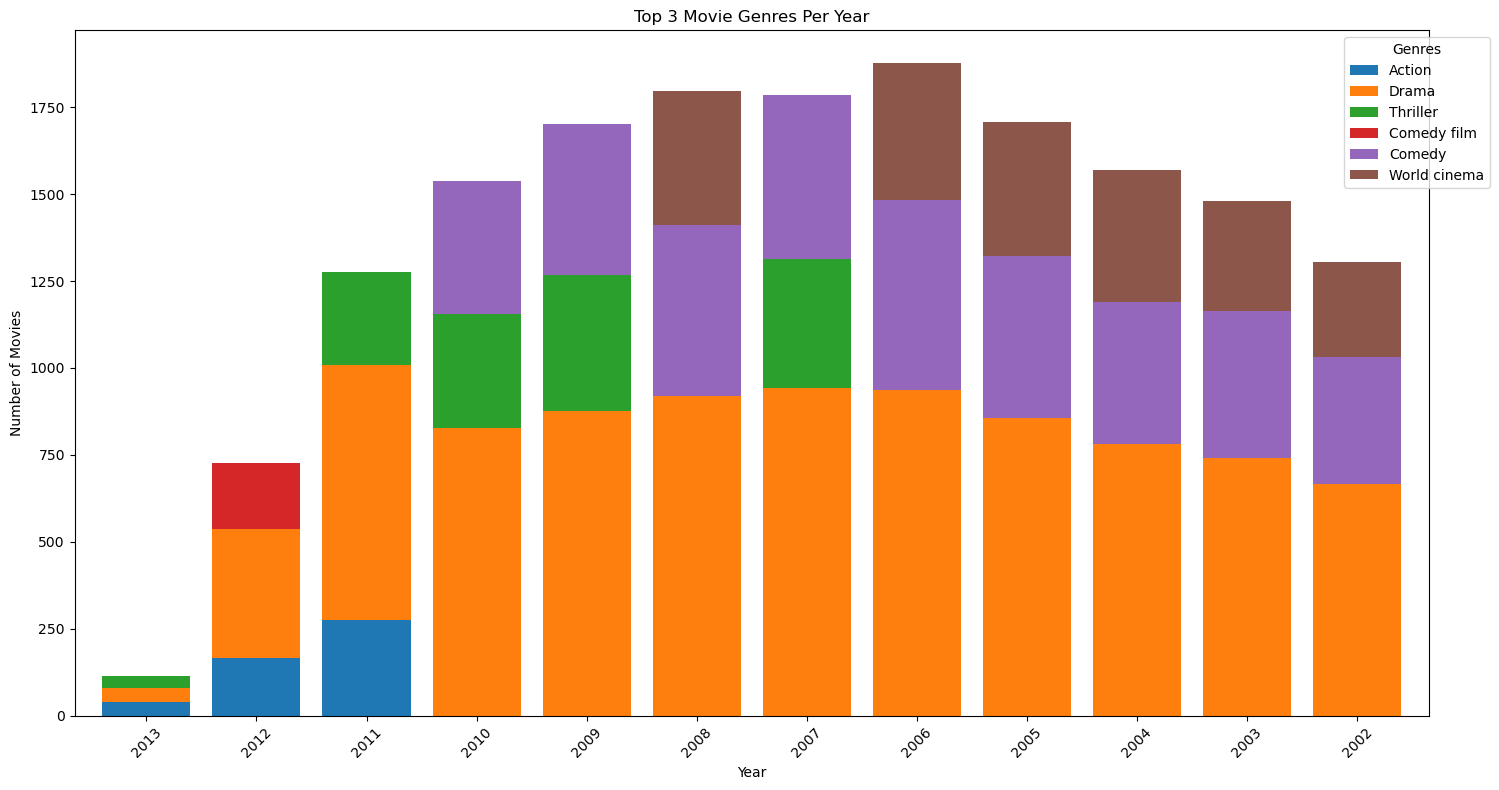

In [43]:
plot_top_genres_by_year(movies_with_characters)

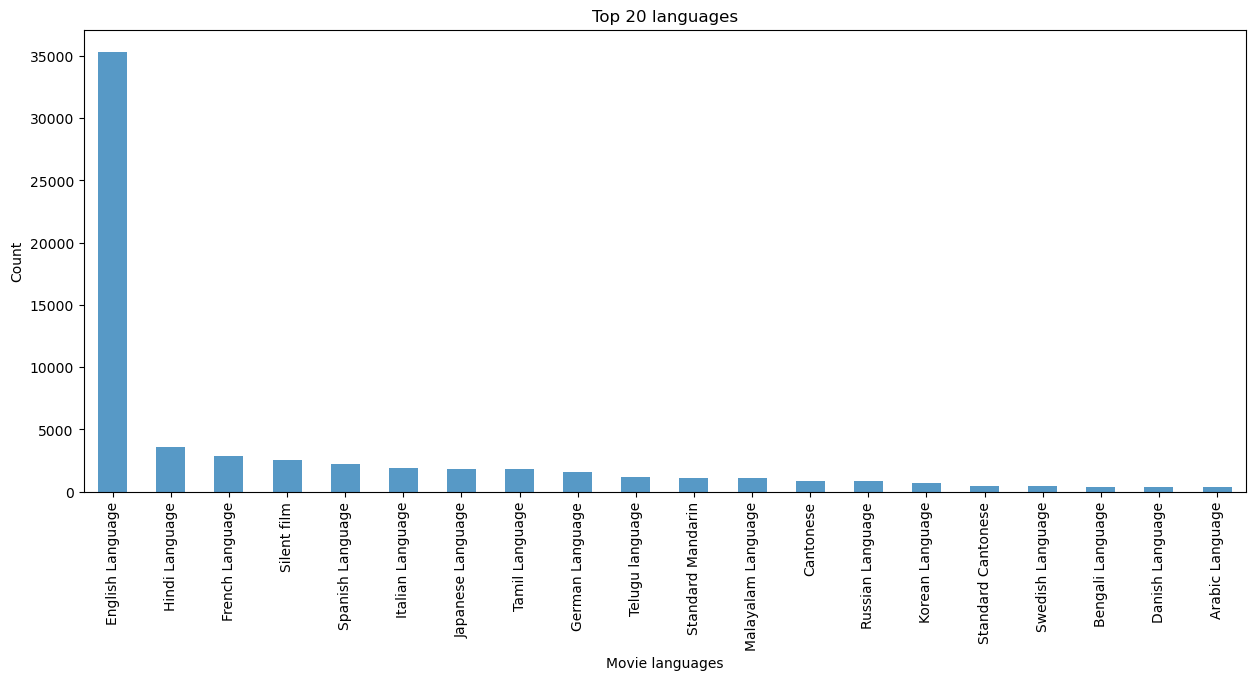

In [47]:
plot_top_languages(movies_with_characters)

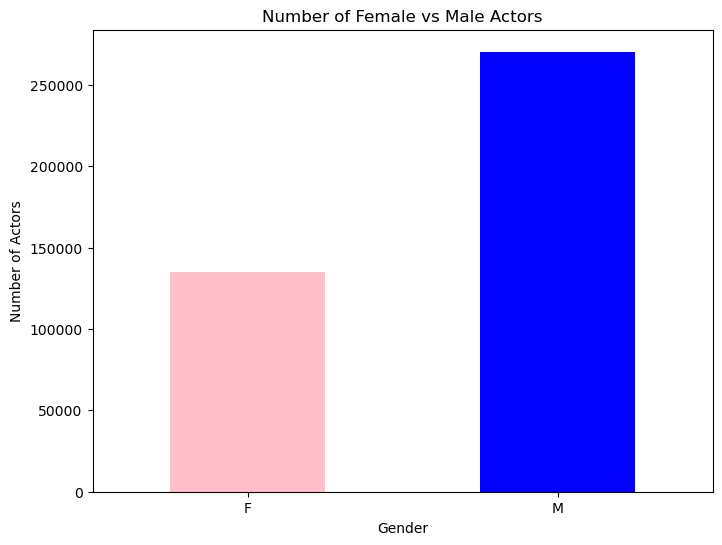

In [49]:
plot_gender_distribution(movies_with_characters)

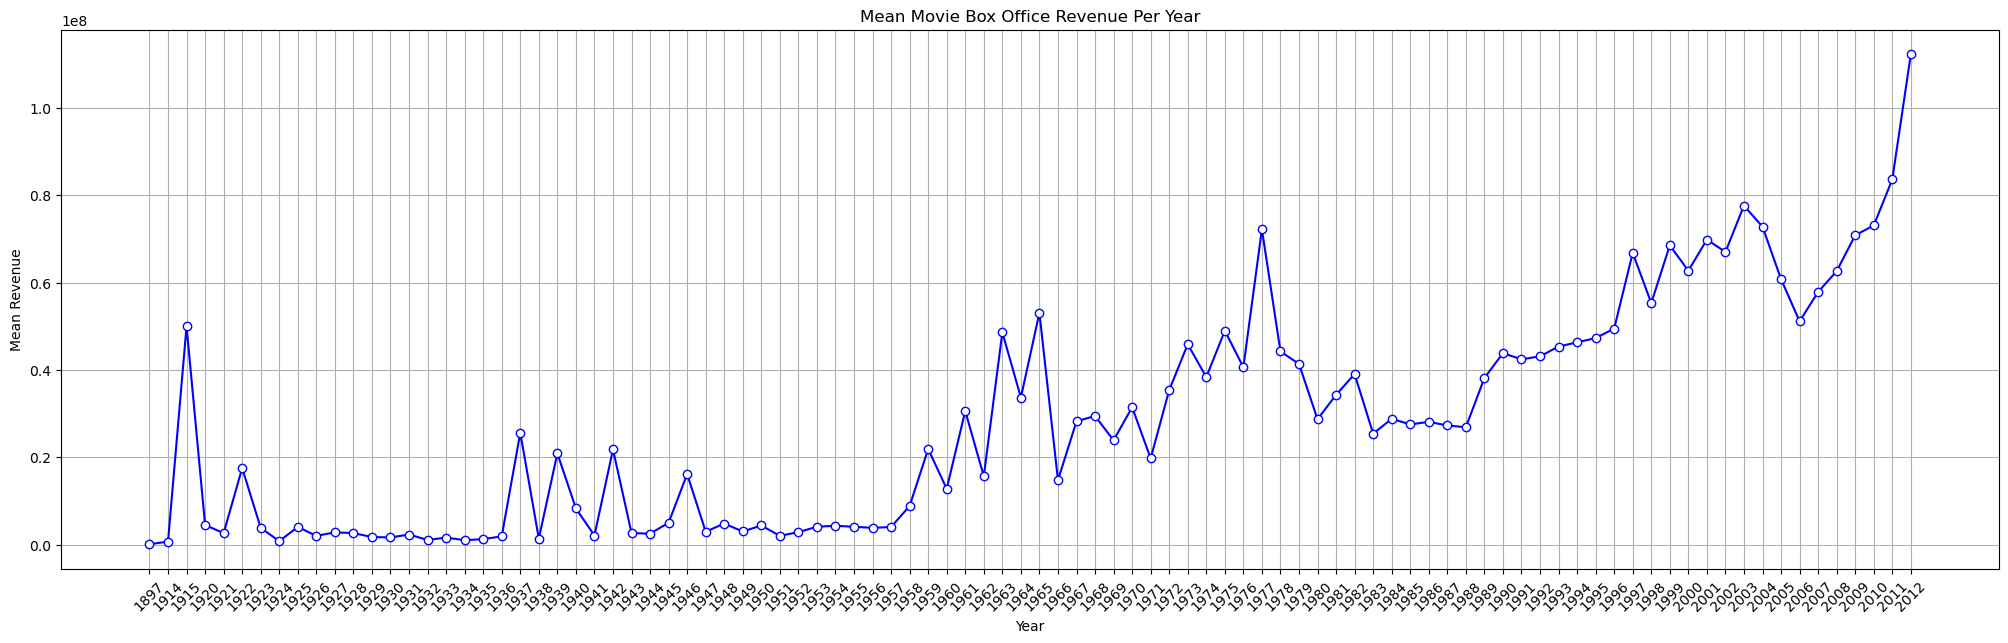

In [51]:
plot_mean_revenue_per_year(movies_with_characters)

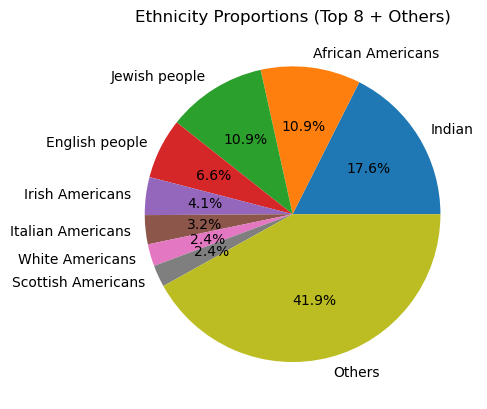

In [53]:
plot_ethnicity_proportions(movies_with_characters)

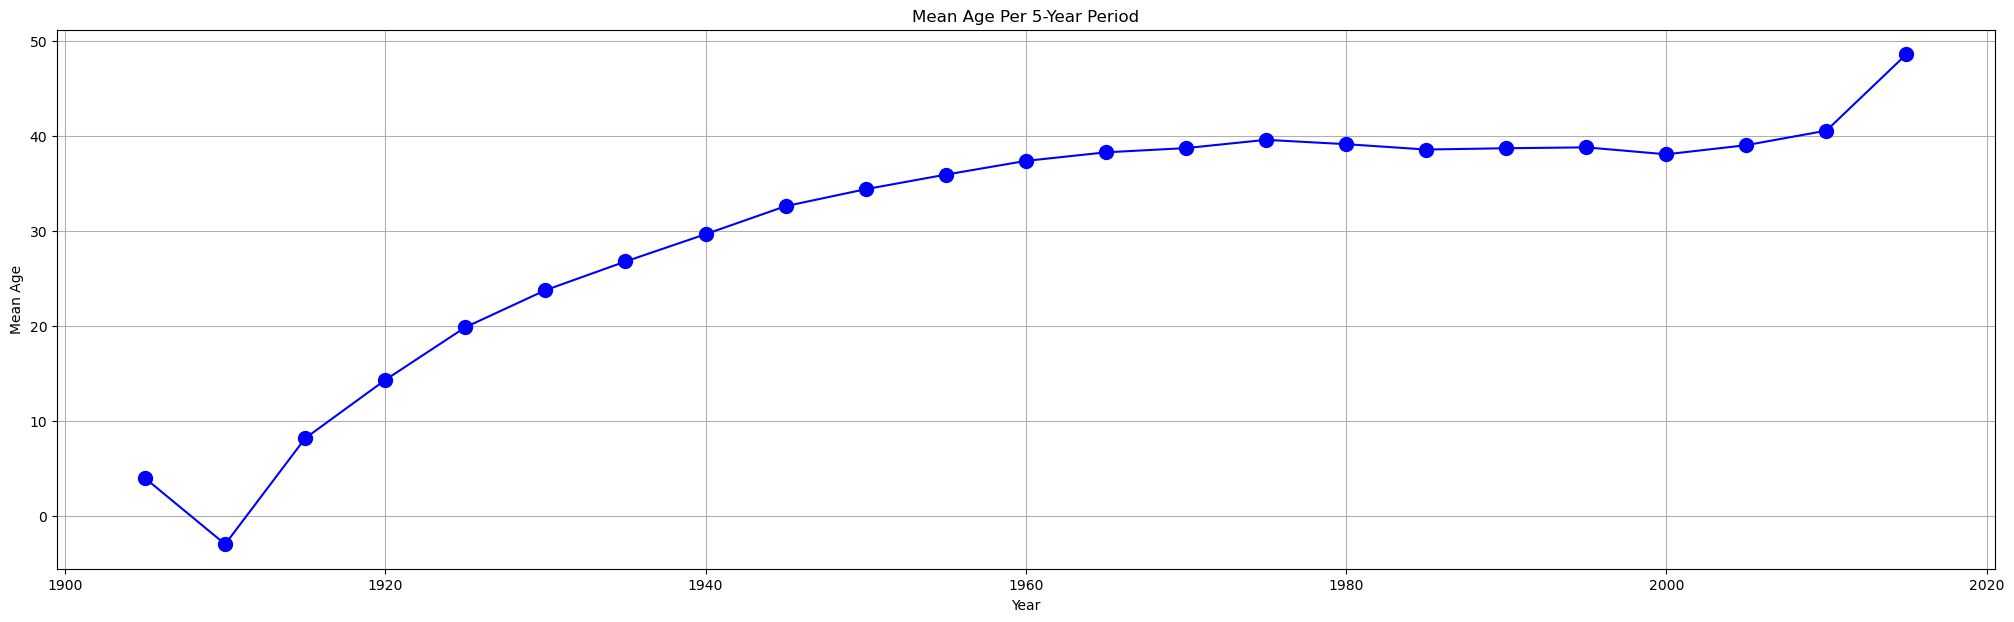

In [55]:
plot_mean_age_per_period(movies_with_characters)

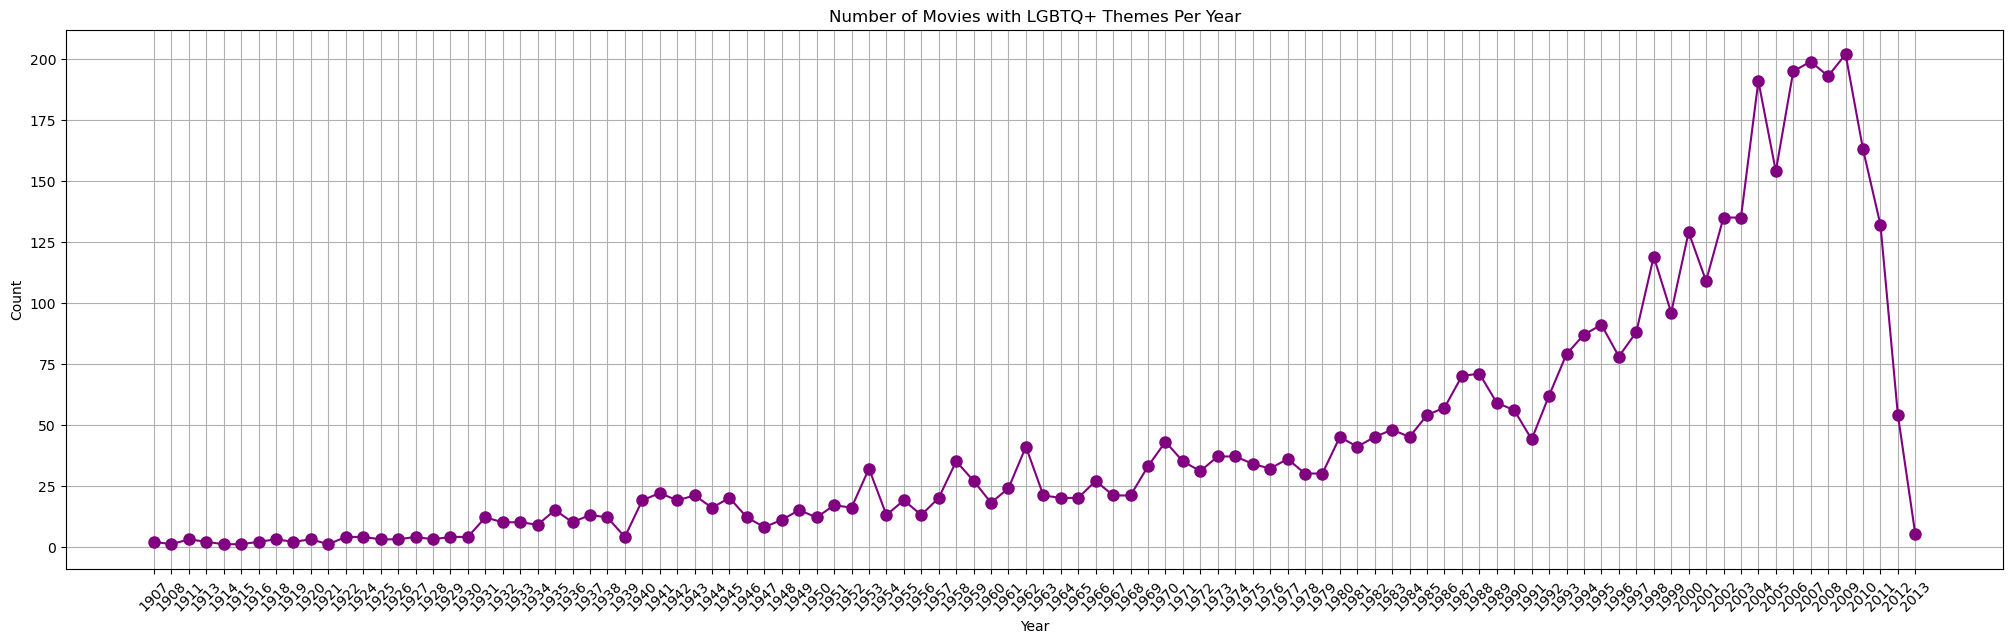

In [57]:
plot_lgbtq_movies_per_year(movies_with_characters)

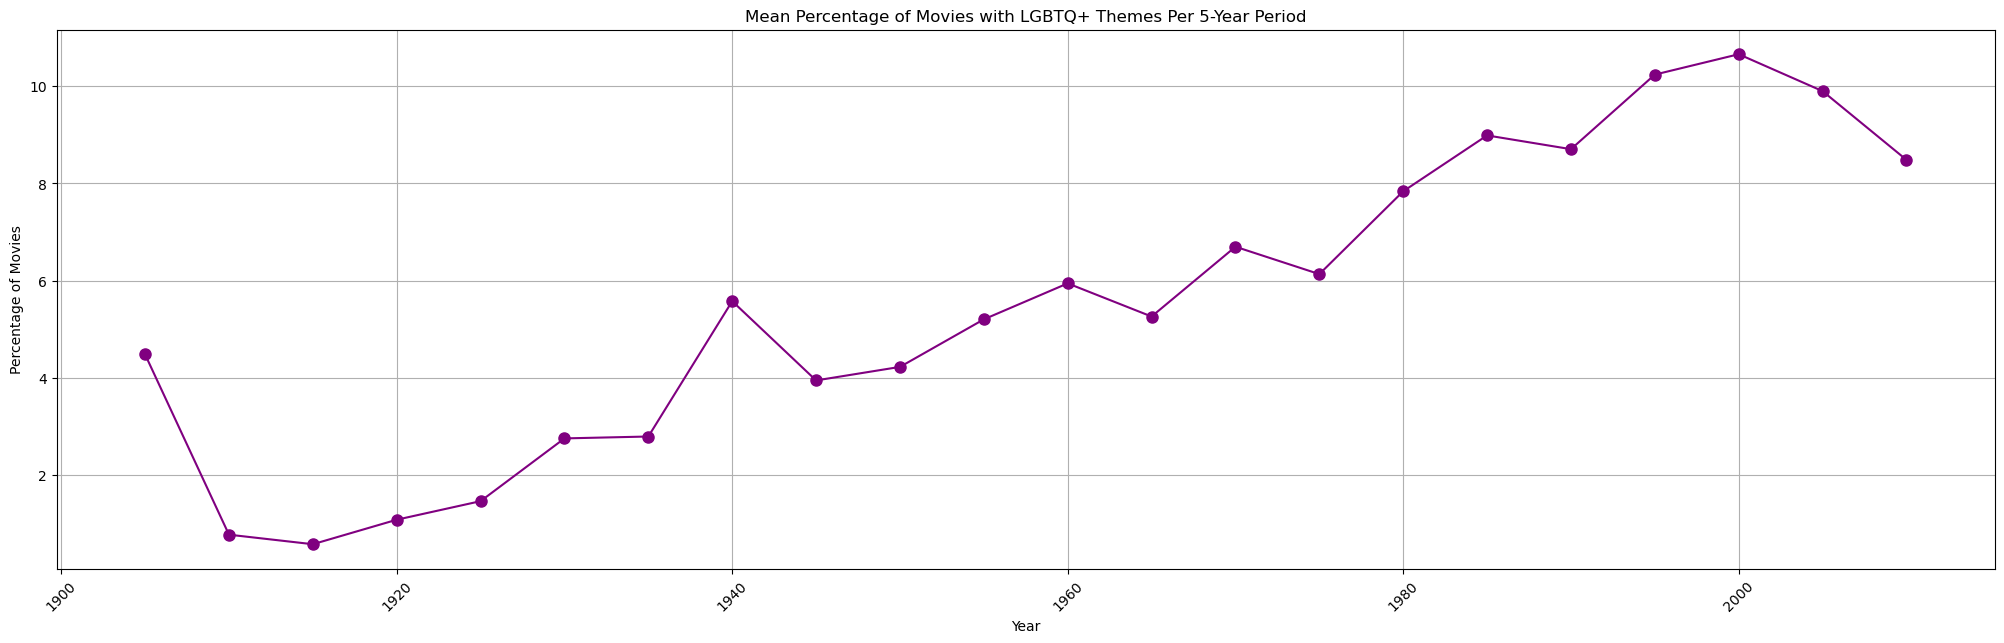

In [59]:
plot_lgbtq_movies_percentage_per_period(movies_with_characters)

Index(['Indian', 'African Americans', 'Jewish people', 'English people',
       'Irish Americans', 'Italian Americans'],
      dtype='object', name='ethnicity')

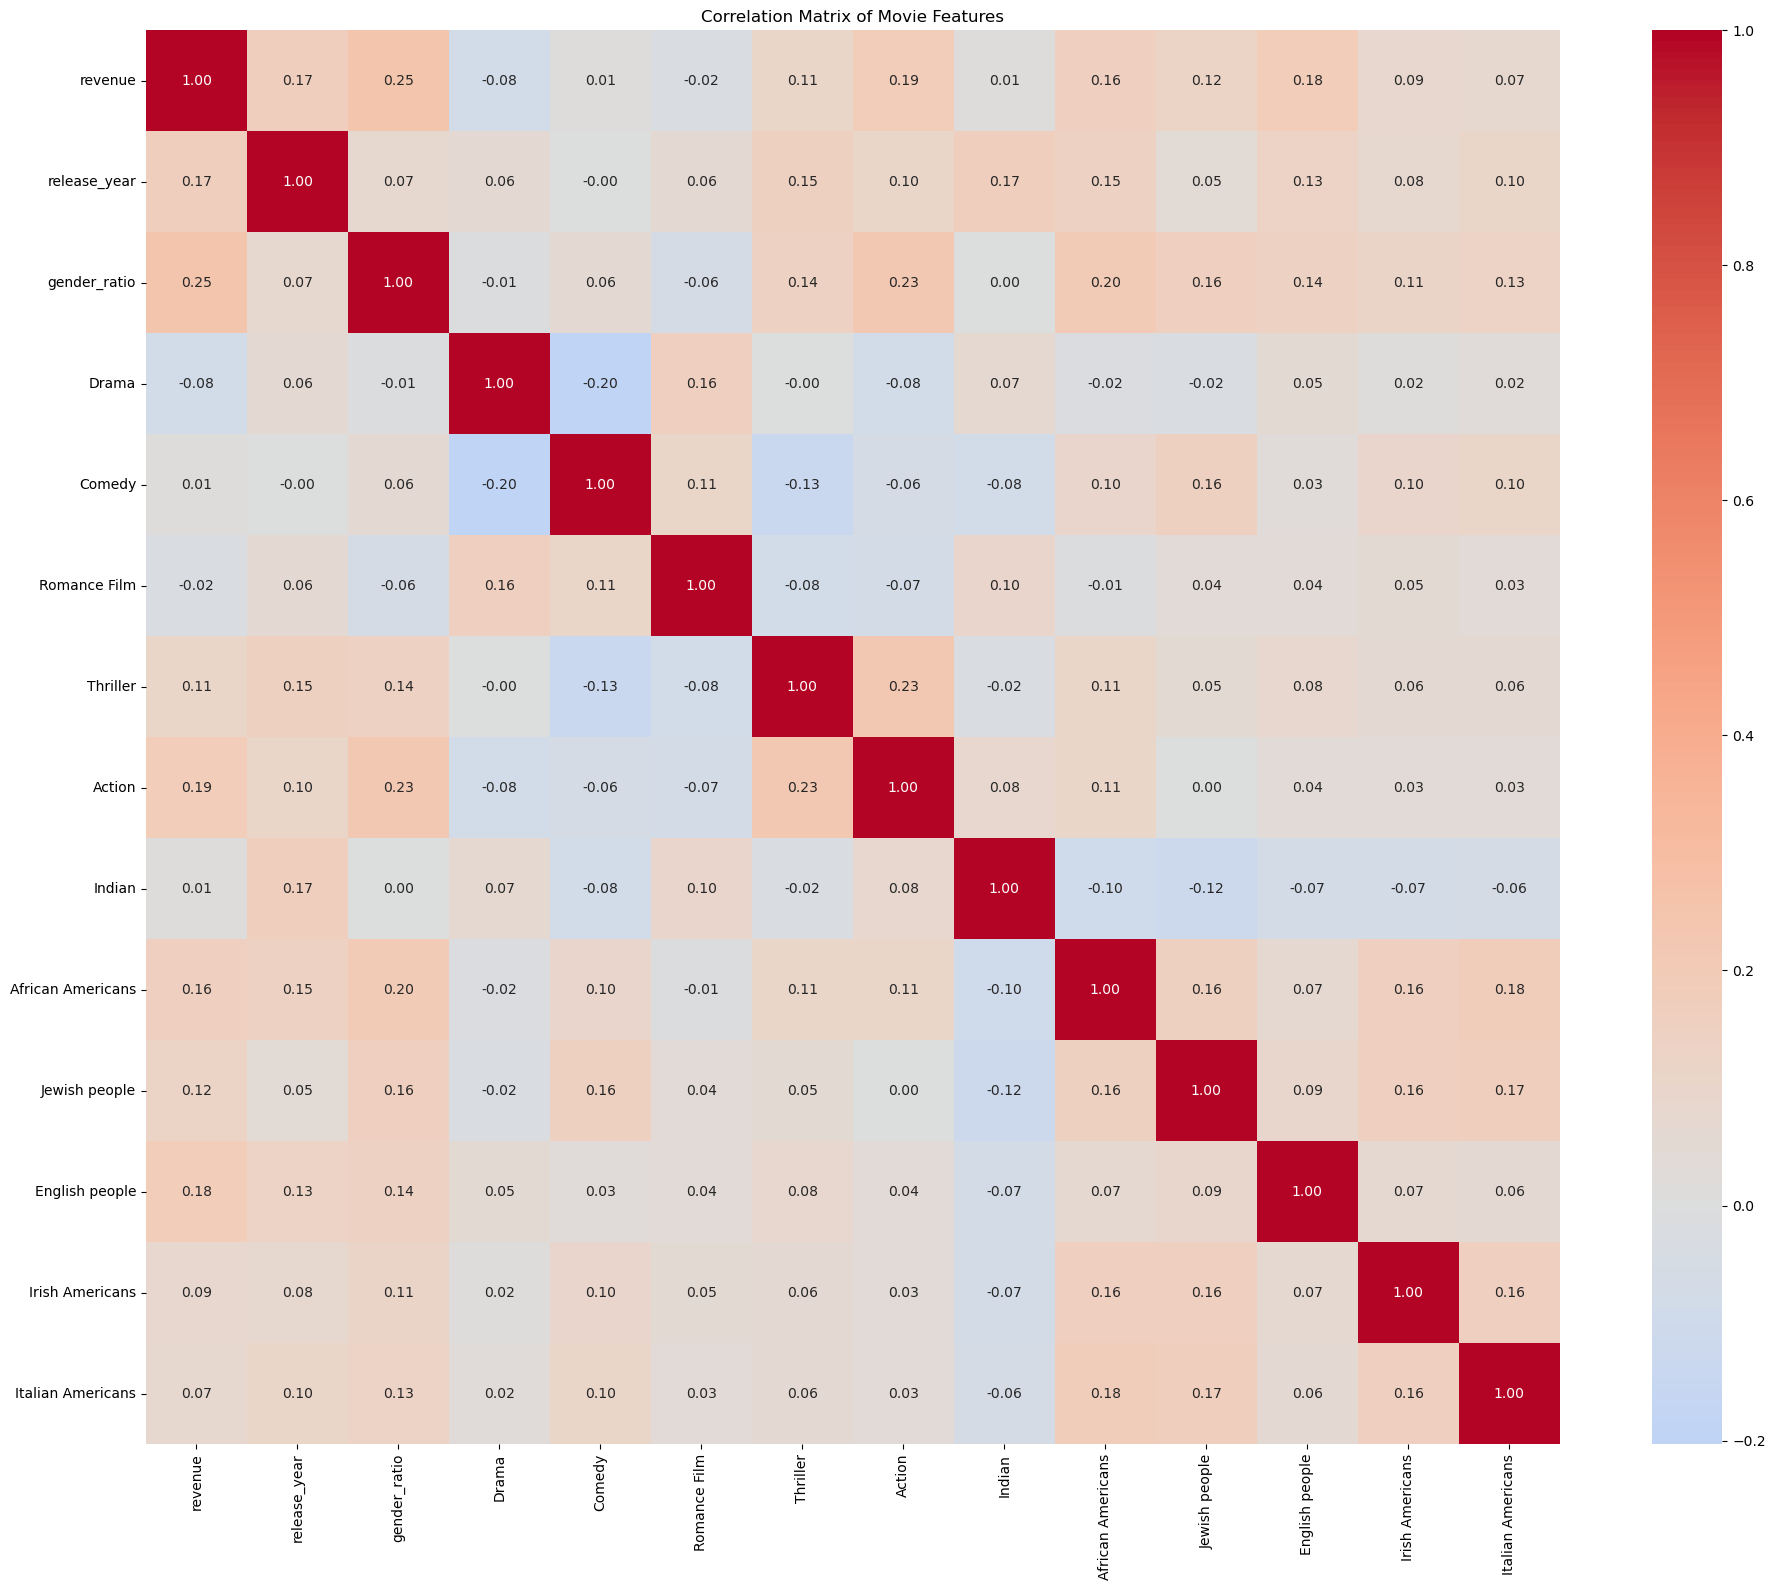


Top 5 positive correlations with revenue:
revenue           1.000000
gender_ratio      0.252731
Action            0.185813
English people    0.184258
release_year      0.166999
Name: revenue, dtype: float64

Top 5 negative correlations with revenue:
Italian Americans    0.073961
Comedy               0.014356
Indian               0.011962
Romance Film        -0.024115
Drama               -0.080775
Name: revenue, dtype: float64


In [31]:
plot_correlation_matrix(movies_with_characters)

20k movies don't have any characters

We will not merge name clusters because there is a baseline bias - we would only consider movies that have been successful and have sequels

In [ ]:
# Add these imports
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess and vectorize the plot text
tfidf = TfidfVectorizer(
    max_features=1000,  # Limit to top 1000 terms
    stop_words="english",
    ngram_range=(1, 2),  # Consider both single words and bigrams
    min_df=5,  # Ignore terms that appear in less than 5 documents
)

# Create document-term matrix
plot_features = tfidf.fit_transform(movies_with_characters["plot"])

# Reduce dimensionality (optional but recommended for better clustering)
svd = TruncatedSVD(n_components=100)
plot_features_reduced = svd.fit_transform(plot_features)

# Cluster the movies
n_clusters = 20  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
movies_with_characters["cluster"] = kmeans.fit_predict(plot_features_reduced)


# Analyze the clusters
def get_top_terms_per_cluster():
    # Get the cluster centers in terms of the original TF-IDF features
    original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)

    for cluster in range(n_clusters):
        top_indices = np.argsort(original_space_centroids[cluster])[
            -10:
        ]  # Top 10 terms
        top_terms = [tfidf.get_feature_names_out()[i] for i in top_indices]
        print(f"\nCluster {cluster} top terms:")
        print(", ".join(top_terms))


# Display results
get_top_terms_per_cluster()